# Privacy-Preserving Record Linkage (PPRL): Investigating Dataset Extension Attacks

## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import hickle as hkl
import numpy as np
import string
import sys
from tqdm.notebook import tqdm

from graphMatching.gma import run_gma

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:20:01) [Clang 18.1.8 ]
PyTorch version 2.1.2
Torchvision version 0.16.2
Numpy version 1.24.4
Pandas version 2.0.3


## Run GMA

In [3]:
# Parameters
GLOBAL_CONFIG = {
    "Data": "./graphMatching/data/fakename_5k.tsv",
    "Overlap": 0.8,
    "DropFrom": "Both",
    "DevMode": False,  # Development Mode, saves some intermediate results to the /dev directory
    "BenchMode": False,  # Benchmark Mode
    "Verbose": True,  # Print Status Messages?
    "MatchingMetric": "cosine",
    "Matching": "MinWeight",
    "Workers": -1,
    "SaveAliceEncs": False,
    "SaveEveEncs": False
}

ENC_CONFIG = {
    "AliceAlgo": "BloomFilter",
    "AliceSecret": "SuperSecretSalt1337",
    "AliceN": 2,
    "AliceMetric": "dice",
    "EveAlgo": "None",
    "EveSecret": "ATotallyDifferentString42",
    "EveN": 2,
    "EveMetric": "dice",
    # For BF encoding
    "AliceBFLength": 1024,
    "AliceBits": 10,
    "AliceDiffuse": False,
    "AliceT": 10,
    "AliceEldLength": 1024,
    "EveBFLength": 1024,
    "EveBits": 10,
    "EveDiffuse": False,
    "EveT": 10,
    "EveEldLength": 1024,
    # For TMH encoding
    "AliceNHash": 1024,
    "AliceNHashBits": 64,
    "AliceNSubKeys": 8,
    "Alice1BitHash": True,
    "EveNHash": 1024,
    "EveNHashBits": 64,
    "EveNSubKeys": 8,
    "Eve1BitHash": True,
    # For 2SH encoding
    "AliceNHashFunc": 10,
    "AliceNHashCol": 1000,
    "AliceRandMode": "PNG",
    "EveNHashFunc": 10,
    "EveNHashCol": 1000,
    "EveRandMode": "PNG",
    # For PST Encoding
    "AlicePSTK": 20,
    "AlicePSTL": 8,
    "AlicePSTP": None,
    "AliceCharset": string.printable,
    "EvePSTK": 20,
    "EvePSTL": 8,
    "EvePSTP": None,
    "EveCharset": string.printable
}

EMB_CONFIG = {
    "Algo": "Node2Vec",
    "AliceQuantile": 0.9,
    "AliceDiscretize": False,
    "AliceDim": 128,
    "AliceContext": 10,
    "AliceNegative": 1,
    "AliceNormalize": True,
    "EveQuantile": 0.9,
    "EveDiscretize": False,
    "EveDim": 128,
    "EveContext": 10,
    "EveNegative": 1,
    "EveNormalize": True,
    # For Node2Vec
    "AliceWalkLen": 100,
    "AliceNWalks": 20,
    "AliceP": 250,
    "AliceQ": 300,
    "AliceEpochs": 5,
    "AliceSeed": 42,
    "EveWalkLen": 100,
    "EveNWalks": 20,
    "EveP": 250,
    "EveQ": 300,
    "EveEpochs": 5,
    "EveSeed": 42
}

ALIGN_CONFIG = {
    "RegWS": max(0.1, GLOBAL_CONFIG["Overlap"]/2), #0005
    "RegInit":0.25, # For BF 0.25
    "Batchsize": 1, # 1 = 100%
    "LR": 200.0,
    "NIterWS": 100,
    "NIterInit": 5 ,  # 800
    "NEpochWS": 100,
    "LRDecay": 1,
    "Sqrt": True,
    "EarlyStopping": 10,
    "Selection": "None",
    "MaxLoad": None,
    "Wasserstein": True
}

In [ ]:
reidentified_individuals, not_reidentified_individuals = run_gma(GLOBAL_CONFIG, ENC_CONFIG, EMB_CONFIG, ALIGN_CONFIG)

df_reidentified_individuals = pd.DataFrame(reidentified_individuals[1:], columns=reidentified_individuals[0])
df_not_reidentified_individuals = pd.DataFrame(not_reidentified_individuals[1:], columns=not_reidentified_individuals[0])

In [2]:

reidentified_individuals = pd.read_csv('./data/available_to_eve/reidentified_individuals.tsv', delimiter='\t')
df_reidentified_individuals = reidentified_individuals

not_reidentified_individuals = hkl.load('./data/available_to_eve/not_reidentified_individuals.h5')
df_not_reidentified_individuals = pd.DataFrame(not_reidentified_individuals[1:], columns=not_reidentified_individuals[0])

In [4]:
print('Reidentified Individuals:')
print(df_reidentified_individuals.head())  
print('Not Reidentified Individuals:')
print(df_not_reidentified_individuals.head())

Reidentified Individuals:
  GivenName  Surname    Birthday  \
0      Todd   Morton    9/9/1969   
1     Kevin  Milazzo  10/25/1957   
2   Debroah    Hamel    6/2/1999   
3     Frank  Elliott   11/8/1955   
4   Michael  Goldman   1/16/1987   

                                         bloomfilter    uid  
0  0000000001000000000010001110100000000001100000...  77675  
1  0000000011000000011100000100000000000100110010...  59614  
2  0001100000000000000000000110000100101000100110...  16013  
3  1000010000000000000000001000010010000010110000...  98431  
4  0001011010100100010100000000000010000000100000...  74542  
Not Reidentified Individuals:
                                         bloomfilter    uid
0  0101000001000000000010001110000000100010100000...  85558
1  0000000000001000000000001000000000000001100000...  22766
2  1000000000000000010101100000000100000100000010...  14271
3  0001000000000001100100000000000000000100100010...  75935
4  1001010000000001000000000010000110100110100010...  3

## Define Dataset

In [6]:
class BloomFilterDataset(Dataset):
    def __init__(self, data, isLabeled=False, all_two_grams=None):
        self.isLabeled = isLabeled
        self.allTwoGrams = all_two_grams
        self.data = data  
        if self.isLabeled:
            # For reidentified data, extract labels (2-grams) from values except last two columns which are encoding and uid
            self.data['label'] = self.data.apply(lambda row: self.extract_two_grams("".join(row.iloc[:-3].astype(str))), axis=1)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        bloom_filter = self.data.iloc[idx]['bloomfilter']
        bloom_filter_tensor = self.bloomfilter_to_tensor(bloom_filter)

        if self.isLabeled:
            label = self.data.iloc[idx]['label']
            label_tensor = self.label_to_tensor(label)
            return bloom_filter_tensor, label_tensor
        else:
            # For unlabeled data (not_reidentified_individuals.tsv), just return the Bloom Filter
            return bloom_filter_tensor
    
    def extract_two_grams(self, input_string):
        input_string_preprocessed = input_string.replace('"', '').replace('.', '').replace('/', '').strip()
        input_string_lower = input_string_preprocessed.lower()  # Normalize to lowercase for consistency
        return [input_string_lower[i:i+2] for i in range(len(input_string_lower)-1) if ' ' not in input_string_lower[i:i+2]]
    
    def bloomfilter_to_tensor(self, bloom_filter_str):
        bloom_filter_array = np.array([int(bit) for bit in bloom_filter_str], dtype=np.float32)
        return torch.tensor(bloom_filter_array)
    
    def label_to_tensor(self, label_two_grams):
        label_vector = np.zeros(len(self.allTwoGrams), dtype=np.float32)
        
        # Set 1 for the 2-grams present in the name
        for gram in label_two_grams:
            if gram in self.allTwoGrams:
                index = self.allTwoGrams.index(gram)
                label_vector[index] = 1
        
        return torch.tensor(label_vector)

## Create Datasets 

In [7]:
#Generate all 2-grams
alphabet = string.ascii_lowercase
# Generate all letter-letter 2-grams (aa-zz)
alphabet = string.ascii_lowercase
letter_letter_grams = [a + b for a in alphabet for b in alphabet]

# Generate all digit-digit 2-grams (00-99)
digits = string.digits
digit_digit_grams = [d1 + d2 for d1 in digits for d2 in digits]

# Generate all letter-digit 2-grams (a0-z9)
letter_digit_grams = [l + d for l in alphabet for d in digits]

# Combine all sets
all_two_grams = letter_letter_grams  + letter_digit_grams + digit_digit_grams 

# Get a dictionary associating each 2-gram with an index
two_gram_dict = {i: two_gram for i, two_gram in enumerate(all_two_grams)}

# Create Datasets
data_labeled = BloomFilterDataset(df_reidentified_individuals, isLabeled=True, all_two_grams=all_two_grams)
data_not_labeled = BloomFilterDataset(df_not_reidentified_individuals, isLabeled=False, all_two_grams=all_two_grams)
bloomfilter_length = len(data_labeled[0][0])

{0: 'aa', 1: 'ab', 2: 'ac', 3: 'ad', 4: 'ae', 5: 'af', 6: 'ag', 7: 'ah', 8: 'ai', 9: 'aj', 10: 'ak', 11: 'al', 12: 'am', 13: 'an', 14: 'ao', 15: 'ap', 16: 'aq', 17: 'ar', 18: 'as', 19: 'at', 20: 'au', 21: 'av', 22: 'aw', 23: 'ax', 24: 'ay', 25: 'az', 26: 'ba', 27: 'bb', 28: 'bc', 29: 'bd', 30: 'be', 31: 'bf', 32: 'bg', 33: 'bh', 34: 'bi', 35: 'bj', 36: 'bk', 37: 'bl', 38: 'bm', 39: 'bn', 40: 'bo', 41: 'bp', 42: 'bq', 43: 'br', 44: 'bs', 45: 'bt', 46: 'bu', 47: 'bv', 48: 'bw', 49: 'bx', 50: 'by', 51: 'bz', 52: 'ca', 53: 'cb', 54: 'cc', 55: 'cd', 56: 'ce', 57: 'cf', 58: 'cg', 59: 'ch', 60: 'ci', 61: 'cj', 62: 'ck', 63: 'cl', 64: 'cm', 65: 'cn', 66: 'co', 67: 'cp', 68: 'cq', 69: 'cr', 70: 'cs', 71: 'ct', 72: 'cu', 73: 'cv', 74: 'cw', 75: 'cx', 76: 'cy', 77: 'cz', 78: 'da', 79: 'db', 80: 'dc', 81: 'dd', 82: 'de', 83: 'df', 84: 'dg', 85: 'dh', 86: 'di', 87: 'dj', 88: 'dk', 89: 'dl', 90: 'dm', 91: 'dn', 92: 'do', 93: 'dp', 94: 'dq', 95: 'dr', 96: 'ds', 97: 'dt', 98: 'du', 99: 'dv', 100: 'dw'

## Create Dataloader

In [8]:
# Split proportions
train_size = int(0.8 * len(data_labeled))  # 80% training
val_size = len(data_labeled) - train_size  # 20% validation

# Split dataset
data_train, data_val = random_split(data_labeled, [train_size, val_size])
dataloader_train = DataLoader(data_train, batch_size=32, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=32, shuffle=True)
dataloader_test = DataLoader(data_not_labeled, batch_size=32, shuffle=False)

## Pytorch Model

In [9]:
class BloomFilterToTwoGramClassifier(nn.Module):
    def __init__(self, input_dim, num_two_grams, hidden_layer=512):
        super(BloomFilterToTwoGramClassifier, self).__init__()
        
        # Define the layers for multi-label classification of 2-grams
        self.model = nn.Sequential(
        nn.Linear(input_dim, hidden_layer),  # Input => first hidden layer
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(hidden_layer, hidden_layer),  # First hidden layer => second hidden layer
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(hidden_layer, num_two_grams),  # Second hidden layer => output layer
        )

    def forward(self, x):
        # Forward pass through the model
        output = self.model(x)
        return output

In [10]:
model = BloomFilterToTwoGramClassifier(input_dim=bloomfilter_length, num_two_grams=len(all_two_grams))

## Training Loop

In [11]:
# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss function for multi-label classification
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [12]:
# Number of epochs
num_epochs = 15
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    for bloom_filters, labels in tqdm(dataloader_train, desc="Training loop"):
        # Move data to device
        bloom_filters, labels = bloom_filters.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(bloom_filters)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(dataloader_train.dataset)
    train_losses.append(train_loss)

    #Validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for bloom_filters, labels in tqdm(dataloader_val, desc="Validation loop"):
            # Move data to device
            bloom_filters, labels = bloom_filters.to(device), labels.to(device)
            
            outputs = model(bloom_filters)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
        val_loss = running_loss / len(dataloader_val.dataset)
        val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}, Validation loss: {val_loss:.4f}")

Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 1/15 - Train loss: 0.1628, Validation loss: 0.0428


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 2/15 - Train loss: 0.0443, Validation loss: 0.0419


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 3/15 - Train loss: 0.0430, Validation loss: 0.0406


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 4/15 - Train loss: 0.0412, Validation loss: 0.0385


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 5/15 - Train loss: 0.0386, Validation loss: 0.0358


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 6/15 - Train loss: 0.0359, Validation loss: 0.0332


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 7/15 - Train loss: 0.0334, Validation loss: 0.0308


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 8/15 - Train loss: 0.0310, Validation loss: 0.0287


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 9/15 - Train loss: 0.0289, Validation loss: 0.0268


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 10/15 - Train loss: 0.0271, Validation loss: 0.0251


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 11/15 - Train loss: 0.0254, Validation loss: 0.0235


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 12/15 - Train loss: 0.0240, Validation loss: 0.0221


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 13/15 - Train loss: 0.0226, Validation loss: 0.0208


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 14/15 - Train loss: 0.0213, Validation loss: 0.0197


Training loop:   0%|          | 0/167 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 15/15 - Train loss: 0.0202, Validation loss: 0.0186


## Visualize Losses

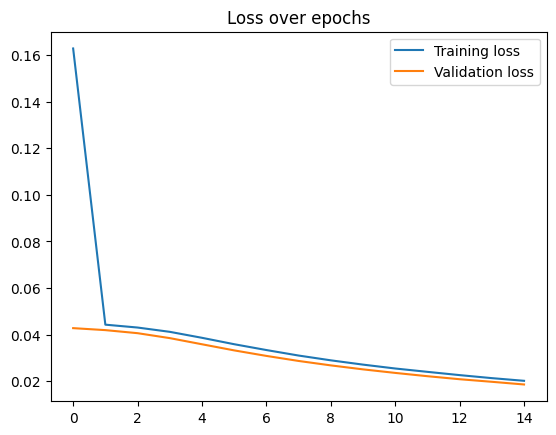

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

## Testing Area

In [ ]:
# First entry for reference (labeled data):
# surname                                                  Hegarty
# firstname                                    Miss. Hanora "Nora"
# bloomfilter    0000000010100011000100000101000000000000100000001000000000100111011000001001100100000100000000001000000000000000001000100000000000010010000000000000100010001110110111000000000000100000000100000001010000000000100101000011000010001010000001000000000000000000001000011010011001000100000011100100000000000011000100100000110011000000000010000000000010000000000000110000000110000000000010000000011100000001000000100000001100101011001000000000010000001000000000001000010110110000000001001000100001010111010000000010000000111000000000010010110000000000001000000101010001000000001000001000010000100110000111001110000000001010011110000100000000000100000001100001100000000000010000000000000000000000100000000010000001000000000011100000000000001000101000010100001001000011000000000010001100000000100000001000001000000000100000101000000000000000000010000000100000000100001000000100000000000000011100000001001000000001100010000001000001000000000000010100100000000110101110010000010000010100000000011000001000000001110000101001000010101111
# uid                                                          654
# Name: 0, dtype: object
#print('Length Labeled data:', len(data_labeled))
#print('Length Unlabeled data:', len(data_not_labeled))

#bloomfilter_tensor, label_tensor = data_labeled[0]

#print('Bloom Filter Tensor:', bloomfilter_tensor)
#print('Bloom Filter Tensor Shape:', bloomfilter_tensor.shape)
#print('Label Tensor:', label_tensor)
#print('Label Tensor Shape:', label_tensor.shape)

#for bloomfilter_tensors, label_tensors in dataloader_train:
#    print('Bloom Filter Tensor Shape:', bloomfilter_tensors.shape)
#    print('Label Tensor Shape:', label_tensors.shape)
#    print(label_tensors)
#    break

#print(str(model)[:500])
#example_bloom, example_label = data_train[0]
#example_out = model(example_bloom)
#print(example_out.shape) 
#loss_function_applied = criterion(example_out, example_label)
#print(loss_function_applied)
#print(example_out)

print(data_labeled[0])
 
# Apply model
result = model(bloomfilter_tensor)
# Result = Tensor of shape 676 with prob. for each 2gram
two_gram_scores = {two_gram_dict[i]: score.item() for i, score in enumerate(result)}

threshold = 0.000000001
filtered_two_gram_scores = {two_gram: score for two_gram, score in two_gram_scores.items() if score > threshold}
filtered_two_gram_scores

In [18]:
print("To Decode: ",df_not_reidentified_individuals.iloc[1])
#torch.set_printoptions(profile="full")
#torch.set_printoptions(profile="default")
print("BF Tensor: ", data_not_labeled[1])
# Apply model
model.eval()
logits = model(data_not_labeled[1])
probabilities = torch.sigmoid(logits)
print("Prob: ", probabilities)
two_gram_scores = {two_gram_dict[i]: score.item() for i, score in enumerate(probabilities)}
threshold = 0.2
filtered_two_gram_scores = {two_gram: score for two_gram, score in two_gram_scores.items() if score > threshold}
print("Decoded 2grams: ", filtered_two_gram_scores)

# person is: Roy	Jeon	9/19/1975
# to or re
# at tt 

To Decode:  bloomfilter    0000000000001000000000001000000000000001100000...
uid                                                        22766
Name: 1, dtype: object
BF Tensor:  tensor([0., 0., 0.,  ..., 0., 0., 0.])
Prob:  tensor([2.0339e-02, 1.1964e-02, 1.9276e-02,  ..., 4.6033e-05, 2.9569e-05,
        2.9508e-05], grad_fn=<SigmoidBackward0>)
Decoded 2grams:  {'jo': 0.22115670144557953, 'ob': 0.2528606355190277, 'on': 0.9705377221107483, 'ro': 0.9747009873390198, 'so': 0.22710715234279633}


In [ ]:
for bloom_filters, labels in dataloader_train:
    print("Bloom Filters Batch Shape:", bloom_filters.shape)
    print("Labels Batch Shape:", labels.shape)
    break

In [ ]:
model = nn.Linear(20, 5) # predict logits for 5 classes
x = torch.randn(1, 20)
print(x.shape)
y = torch.tensor([[1., 0., 1., 0., 0.]]) # get classA and classC as active
print(y.shape)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-1)

for epoch in range(20):
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    print('Loss: {:.3f}'.format(loss.item()))

In [ ]:
for bloom_filters, labels in dataloader_train:
    print("Bloom Filters Batch Shape:", bloom_filters[0])
    print("Labels Batch Shape:", labels[0])
    break